<a href="https://colab.research.google.com/github/kruthikn-caps/ML-Assignment-1/blob/main/CS6375_Assignment1_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS6375 Assignment 1 - FFNN & RNN (Sentiment Analysis)

This notebook sets up and runs the FFNN and RNN models for 5-class Yelp review sentiment classification.

**Steps Covered:**
- Upload data and code
- Install dependencies
- Unzip embeddings
- Train FFNN and RNN
- View outputs and error plots

In [1]:
from google.colab import files
uploaded = files.upload()


Saving Data_Embedding.zip to Data_Embedding.zip
Saving rnn.py to rnn.py
Saving test.json to test.json
Saving training.json to training.json
Saving validation.json to validation.json
Saving ffnn.py to ffnn.py


In [2]:
!pip install torch tqdm matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [4]:
import zipfile
with zipfile.ZipFile("Data_Embedding.zip", 'r') as zip_ref:
    zip_ref.extractall("embedding")


Epoch 1 Train Accuracy: 0.4794
Epoch 1 Validation Accuracy: 0.5675
Epoch 2 Train Accuracy: 0.5724
Epoch 2 Validation Accuracy: 0.5950
Epoch 3 Train Accuracy: 0.6408
Epoch 3 Validation Accuracy: 0.6175
Epoch 4 Train Accuracy: 0.7037
Epoch 4 Validation Accuracy: 0.6212
Epoch 5 Train Accuracy: 0.7676
Epoch 5 Validation Accuracy: 0.6250
Epoch 6 Train Accuracy: 0.8133
Epoch 6 Validation Accuracy: 0.6375
Epoch 7 Train Accuracy: 0.8550
Epoch 7 Validation Accuracy: 0.6200
Epoch 8 Train Accuracy: 0.8866
Epoch 8 Validation Accuracy: 0.6237
Epoch 9 Train Accuracy: 0.9116
Epoch 9 Validation Accuracy: 0.6100
Epoch 10 Train Accuracy: 0.9367
Epoch 10 Validation Accuracy: 0.6187
Epoch 11 Train Accuracy: 0.9493
Epoch 11 Validation Accuracy: 0.6162
Epoch 12 Train Accuracy: 0.9625
Epoch 12 Validation Accuracy: 0.6212
Epoch 13 Train Accuracy: 0.9721
Epoch 13 Validation Accuracy: 0.6175
Epoch 14 Train Accuracy: 0.9756
Epoch 14 Validation Accuracy: 0.6100
Epoch 15 Train Accuracy: 0.9810
Epoch 15 Validation 

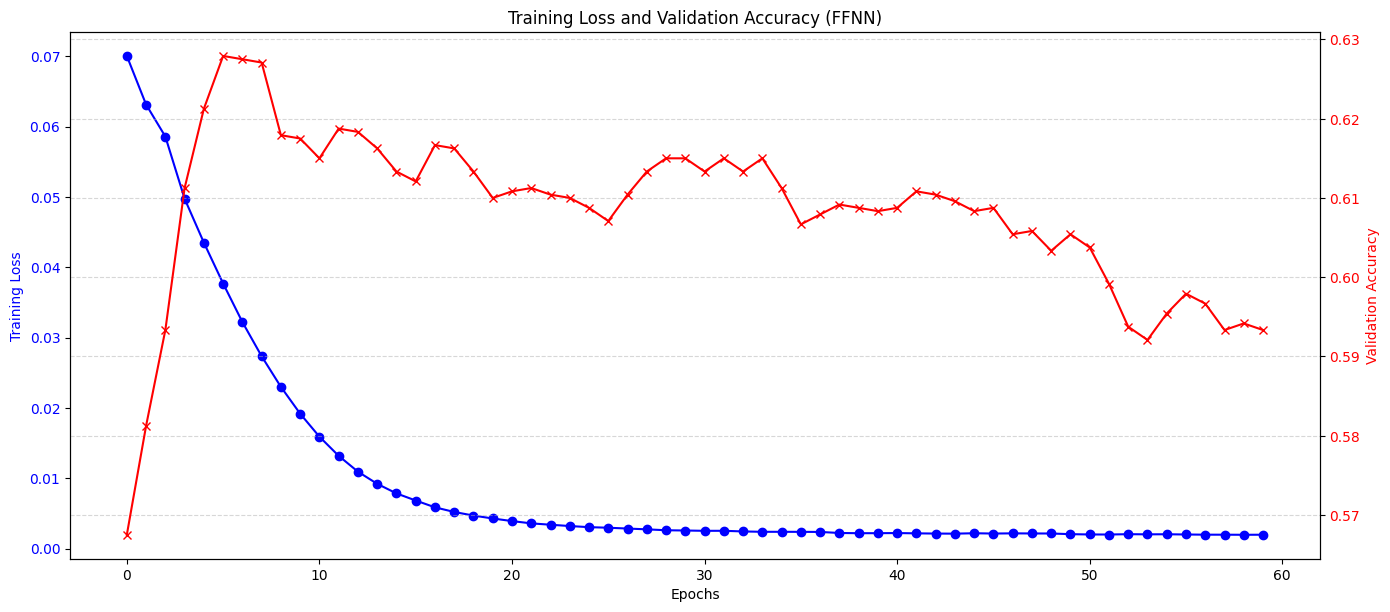

In [28]:
# === Final FFNN for Sentiment Classification (Improved Plot + Early Stopping) ===
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import json
import random

unk = "<UNK>"

class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FFNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, 5),
            nn.LogSoftmax(dim=1)
        )
        self.loss_fn = nn.NLLLoss()

    def forward(self, x):
        return self.model(x)

    def compute_loss(self, y_pred, y_true):
        return self.loss_fn(y_pred, y_true)

def load_data(path):
    with open(path) as f:
        raw = json.load(f)
    return [(d["text"].split(), int(d["stars"]) - 1) for d in raw]

def build_vocab(data):
    vocab = set()
    for doc, _ in data:
        vocab.update(doc)
    vocab.add(unk)
    return {word: idx for idx, word in enumerate(sorted(vocab))}

def vectorize_data(data, word2idx):
    vecs, labels = [], []
    for doc, y in data:
        vec = torch.zeros(len(word2idx))
        for word in doc:
            vec[word2idx.get(word, word2idx[unk])] += 1
        vec = vec / vec.norm() if vec.norm() > 0 else vec  # Normalize BoW
        vecs.append(vec)
        labels.append(y)
    return vecs, labels

def moving_avg(data, window=3):
    return [sum(data[max(i-window+1, 0):i+1])/len(data[max(i-window+1, 0):i+1]) for i in range(len(data))]

def plot_learning_curve(train_losses, val_accuracies):
    fig, ax1 = plt.subplots(figsize=(14, 6))

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color='blue')
    ax1.plot(train_losses, label='Training Loss', color='blue', marker='o')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Accuracy', color='red')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red', marker='x')
    ax2.tick_params(axis='y', labelcolor='red')

    fig.tight_layout()
    plt.title("Training Loss and Validation Accuracy (FFNN)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig("ffnn_diagnostic_plot.png")
    plt.show()


def train_ffnn(train_vecs, train_labels, val_vecs, val_labels, input_dim, hidden_dim, epochs):
    model = FFNN(input_dim, hidden_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    batch_size = 16
    train_losses, val_accuracies = [], []

    best_val_acc = 0
    wait, patience = 0, 3

    for epoch in range(epochs):
        model.train()
        indices = list(range(len(train_vecs)))
        random.shuffle(indices)
        total_loss, correct, total = 0, 0, 0

        for i in range(0, len(indices), batch_size):
            batch_idx = indices[i:i+batch_size]
            x_batch = torch.stack([train_vecs[j] for j in batch_idx])
            y_batch = torch.tensor([train_labels[j] for j in batch_idx])
            y_pred = model(x_batch)
            loss = model.compute_loss(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (torch.argmax(y_pred, dim=1) == y_batch).sum().item()
            total += len(batch_idx)

        train_losses.append(total_loss / len(indices))
        print(f"Epoch {epoch+1} Train Accuracy: {correct/total:.4f}")

        # Validation
        model.eval()
        with torch.no_grad():
            x_val = torch.stack(val_vecs)
            y_val = torch.tensor(val_labels)
            y_pred = model(x_val)
            acc = (torch.argmax(y_pred, dim=1) == y_val).float().mean().item()
            val_accuracies.append(acc)
            print(f"Epoch {epoch+1} Validation Accuracy: {acc:.4f}")

        # Early stopping
        if acc > best_val_acc:
            best_val_acc = acc
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Warning: No improvement for {patience} epochs (best acc: {best_val_acc:.4f})")


    plot_learning_curve(moving_avg(train_losses), moving_avg(val_accuracies))
    return model

# === Load and Train ===
train_data = load_data("training.json")
val_data = load_data("validation.json")
word2idx = build_vocab(train_data)
train_vecs, train_labels = vectorize_data(train_data, word2idx)
val_vecs, val_labels = vectorize_data(val_data, word2idx)

model = train_ffnn(
    train_vecs, train_labels,
    val_vecs, val_labels,
    input_dim=len(word2idx), hidden_dim=32, epochs=60
)


In [ ]:
# === RNN for Sentiment Classification (Colab-ready) ===
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import json
import pickle
import random
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unk = "<UNK>"

class RNNModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, 5)
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.loss_fn = nn.NLLLoss()

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.dropout(out[:, -1, :])  # last hidden state
        out = self.fc(out)
        return self.log_softmax(out)

    def compute_loss(self, y_pred, y_true):
        return self.loss_fn(y_pred, y_true)

def load_data(path):
    with open(path) as f:
        raw = json.load(f)
    return [(r["text"].split(), int(r["stars"]) - 1) for r in raw]

def load_embeddings(path="embedding/word_embedding.pkl"):
    with open(path, "rb") as f:
        emb = pickle.load(f)
    if unk not in emb:
        emb[unk] = torch.zeros(len(next(iter(emb.values()))))
    return emb

def vectorize_sequence(doc, word_embeddings):
    vectors = [word_embeddings.get(word.lower(), word_embeddings[unk]) for word in doc]
    return torch.tensor(np.array(vectors), dtype=torch.float32)

def moving_avg(data, window=3):
    return [sum(data[max(i-window+1, 0):i+1])/len(data[max(i-window+1, 0):i+1]) for i in range(len(data))]

def plot_learning_curve(train_losses, val_accuracies):
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color='blue')
    ax1.plot(train_losses, label='Training Loss', color='blue', marker='o')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Accuracy', color='red')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red', marker='x')
    ax2.tick_params(axis='y', labelcolor='red')
    plt.title("Training Loss and Validation Accuracy (RNN)")
    fig.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig("rnn_diagnostic_plot.png")
    plt.show()

def train_rnn(train_data, val_data, word_embeddings, hidden_dim, epochs=60):
    embedding_dim = len(next(iter(word_embeddings.values())))
    model = RNNModel(embedding_dim, hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, val_accuracies = [], []
    best_val_acc, wait, patience = 0, 0, 3

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        random.shuffle(train_data)

        for text, label in train_data:
            x = vectorize_sequence(text, word_embeddings).unsqueeze(0).to(device)
            y = torch.tensor([label]).to(device)
            y_pred = model(x)
            loss = model.compute_loss(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (torch.argmax(y_pred, dim=1) == y).sum().item()

        train_losses.append(total_loss / len(train_data))
        print(f"Epoch {epoch+1} Train Accuracy: {correct/len(train_data):.4f}")

        # Validation
        model.eval()
        correct = 0
        with torch.no_grad():
            for text, label in val_data:
                x = vectorize_sequence(text, word_embeddings).unsqueeze(0).to(device)
                y = torch.tensor([label]).to(device)
                y_pred = model(x)
                correct += (torch.argmax(y_pred, dim=1) == y).sum().item()
        val_acc = correct / len(val_data)
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1} Validation Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            wait = 0
            torch.save(model.state_dict(), "best_rnn_model.pt")
            print("💾 Best model saved.")
        else:
            wait += 1
            if wait >= patience:
                print(f" Early stopping at epoch {epoch+1}")
                break

    plot_learning_curve(moving_avg(train_losses), moving_avg(val_accuracies))
    return model

# === Run ===
train_data = load_data("training.json")
val_data = load_data("validation.json")
word_embeddings = load_embeddings()  # Path: embedding/word_embedding.pkl
model = train_rnn(train_data, val_data, word_embeddings, hidden_dim=32, epochs=60)


Epoch 1 Train Accuracy: 0.4150
Epoch 1 Validation Accuracy: 0.4250
💾 Best model saved.
Epoch 2 Train Accuracy: 0.4409
Epoch 2 Validation Accuracy: 0.4500
💾 Best model saved.
